# 一、环境准备

## 1.检查 CUDA 状态

In [1]:
import torch

flag = torch.cuda.is_available()
if flag:
    print("CUDA可使用")
else:
    print("CUDA不可用")

# 获取GPU数量
ngpu = torch.cuda.device_count()
print("GPU数量：",ngpu)
# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")
print("驱动为：",device)
print("GPU型号： ",torch.cuda.get_device_name(0))

CUDA可使用
GPU数量： 2
驱动为： cuda:0
GPU型号：  NVIDIA GeForce RTX 3090


## 2.环境超参

In [2]:
import sys
sys.path.insert(0, '..')

In [3]:
from argparse import Namespace

config = Namespace(
    img_size = 128,
    lr = 1e-4,
    batch_size = 4,
)

# 二、数据准备

## 1.定义数据集

In [4]:
from pathlib import Path


train_imgs = [
    str(x) for x in Path("../datasets/lane_lines/train").rglob("*.jpg")
    if 'checkpoint' not in str(x)
]

val_imgs = [
    str(x) for x in Path('../datasets/lane_lines/val').rglob("*.jpg")
    if 'checkpoint' not in str(x)
]

## 2.定义数据增强方式

In [5]:
import albumentations as A
from albumentations.pytorch import ToTensorV2


train_transforms = A.Compose(
    [
        A.OneOf([
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5),
        ]),
        ToTensorV2(p=1),
    ],
    p=1.0,
)
val_transforms = A.Compose(
    [
        ToTensorV2(p=1),
    ],
    p=1.0,
)


## 3.定义 dataset 和 dataloader

In [6]:
from torch.utils.data import DataLoader
from custom.dataset import CustomDataset

train_dataset = CustomDataset(train_imgs, config.img_size, train_transforms)
val_dataset = CustomDataset(val_imgs, config.img_size, val_transforms)

train_dataloader = DataLoader(train_dataset, batch_size=config.batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=config.batch_size, shuffle=False)

## 4.检查数据

torch.Size([4, 3, 128, 128]) torch.Size([4, 1, 128, 128])


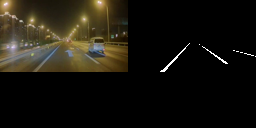

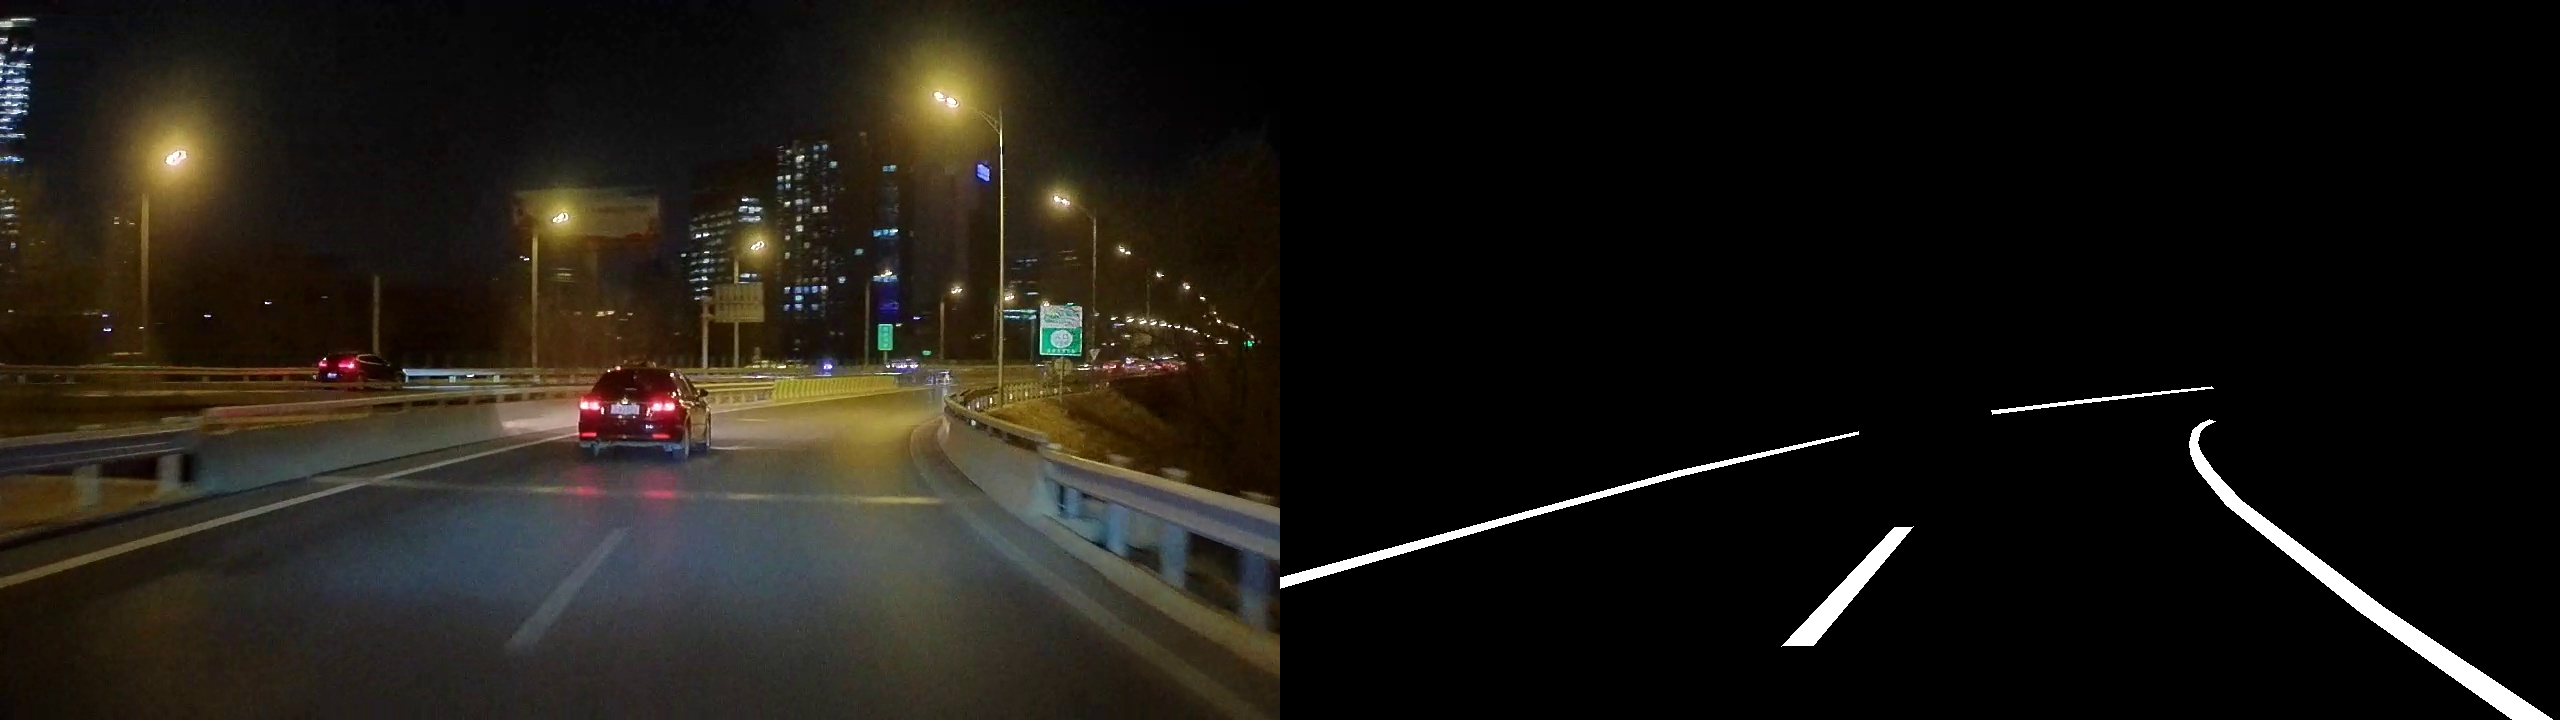

In [7]:
import numpy as np
from PIL import Image
from torchkeras.plots import joint_imgs_row

for batch in train_dataloader:
    image = batch['image']
    mask = batch['mask']
    print(image.shape, mask.shape)
    # tensor -> numpy -> PIL
    image = image[0].permute(1, 2, 0).numpy() * 255
    mask = mask[0].permute(1, 2, 0).numpy().squeeze()
    mask = np.where(mask > 0.5, 255, 0).astype(np.uint8)
    image = Image.fromarray(image.astype(np.uint8))
    mask = Image.fromarray(mask)
    display(joint_imgs_row(image, mask))
    break

display(train_dataset.show_sample(10))

# 三、训练准备

## 1.定义训练 step

这里主要是定义训练的 step 函数，包括前向传播、计算损失、反向传播等，方便自己自定义训练循环。

In [8]:
from importlib import reload
from torchkeras import kerasmodel, pbar
from custom.step import StepRunner

reload(kerasmodel)
reload(pbar)

kerasmodel.KerasModel.StepRunner = StepRunner

## 2.定义优化器、学习率策略、评价指标、模型等

In [9]:
import torch
from torchkeras.metrics import IOU
from torchkeras.models import UNet
from torchkeras.kerasmodel import KerasModel
from custom.loss import MixedLoss, DiceLoss

net = UNet(in_channels=3, num_classes=1)
optim = torch.optim.Adam(net.parameters(), lr=config.lr)
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optim, T_max=8, eta_min=1e-6
)
metrics = {
    "iou": IOU(num_classes=1)
}

model = KerasModel(
    net, loss_fn=MixedLoss(0.5), optimizer=optim, lr_scheduler=lr_scheduler, metrics_dict=metrics
)
print(1)

1


## 3.可视化训练

<<<<<< ⚡️ cuda is used >>>>>>


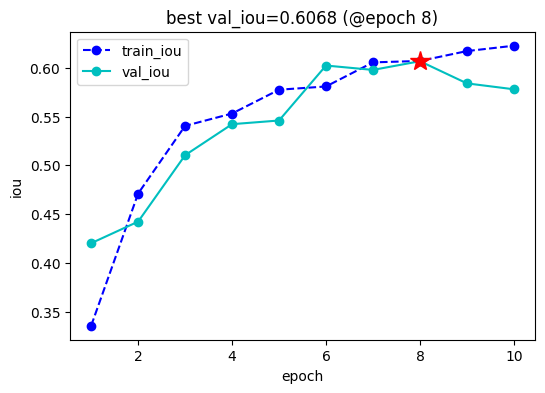

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: zijie-shen795 (uestc-cd). Use `wandb login --relogin` to force relogin


Output()

best_val_iou,▁▂▄▆▆█████
epoch,▁▂▃▃▄▅▆▆▇█
lr,▅▁▅█▅▁▅█▅▁
train_iou,▁▄▆▆▇▇████
train_loss,█▅▄▃▃▂▂▂▁▁
val_iou,▁▂▄▆▆███▇▇
val_loss,█▆▅▃▃▂▁▁▁▁
best_score,0.60676
best_val_iou,0.60676
epoch,10.0
lr,0.0


<<<<<< val_iou without improvement in 2 epoch,early stopping >>>>>> 



In [10]:
from importlib import reload
from torchkeras import kerasmodel, kerascallbacks
reload(kerascallbacks)

from torchkeras.kerascallbacks import WandbCallback
from torchkeras.kerascallbacks import VisDisplay

wandb_cb = WandbCallback(
    project='lane_lines',
    config=config.__dict__,
    name=None,
    save_code=True,
    save_ckpt=True,
)

def display_fn(model):
    from matplotlib import pyplot as plt
    batch = next(iter(val_dataloader))

    with torch.no_grad():
        model.eval()
        logits = model(batch["image"].cuda())
    pr_masks = logits.sigmoid()

    for image, gt_mask, pr_mask in zip(batch["image"][:2], batch["mask"][:2], pr_masks[:2]):
        plt.figure(figsize=(16, 10))

        plt.subplot(1, 3, 1)
        plt.imshow(image.numpy().transpose(1, 2, 0))  # convert CHW -> HWC
        plt.title("Image")
        plt.axis("off")

        plt.subplot(1, 3, 2)
        plt.imshow(gt_mask.numpy().squeeze())
        plt.title("Ground truth")
        plt.axis("off")

        plt.subplot(1, 3, 3)
        plt.imshow(pr_mask.cpu().numpy().squeeze())
        plt.title("Prediction")
        plt.axis("off")

        plt.show()

visdis = VisDisplay(display_fn,model = model,init_display=False)
dfhistory=model.fit(
    train_data=train_dataloader,
    val_data=val_dataloader,
    epochs=20,
    ckpt_path='checkpoint.pt',
    patience=2,
    monitor="val_iou",
    mode="max",
    mixed_precision='no',
    callbacks = [wandb_cb,visdis],
    plot=True,
    cpu=False,
    quiet=True,
)


## 4.查看训练结果

In [11]:
from importlib import reload 
from torchkeras import plots
reload(plots)
from torchkeras.plots import plot_metric 

plot_metric(dfhistory,'iou')

In [12]:
plot_metric(dfhistory,'loss')

# 四、模型验证

In [13]:
model.evaluate(val_dataloader)

100%|██████████████████████████████████| 5/5 [00:00<00:00, 11.20it/s, val_iou=0.607, val_loss=0.617]


{'val_loss': 0.6165648460388183, 'val_iou': 0.6067578792572021}

# 五、模型推理

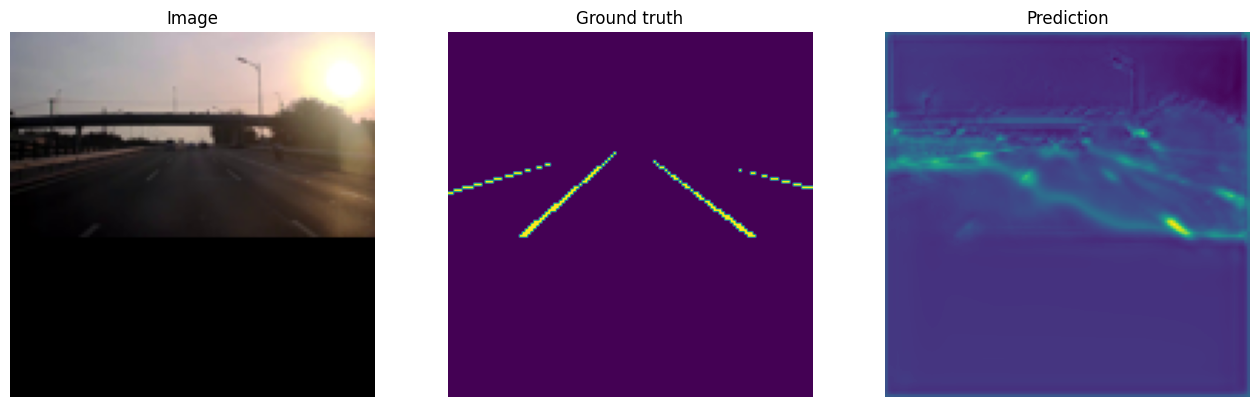

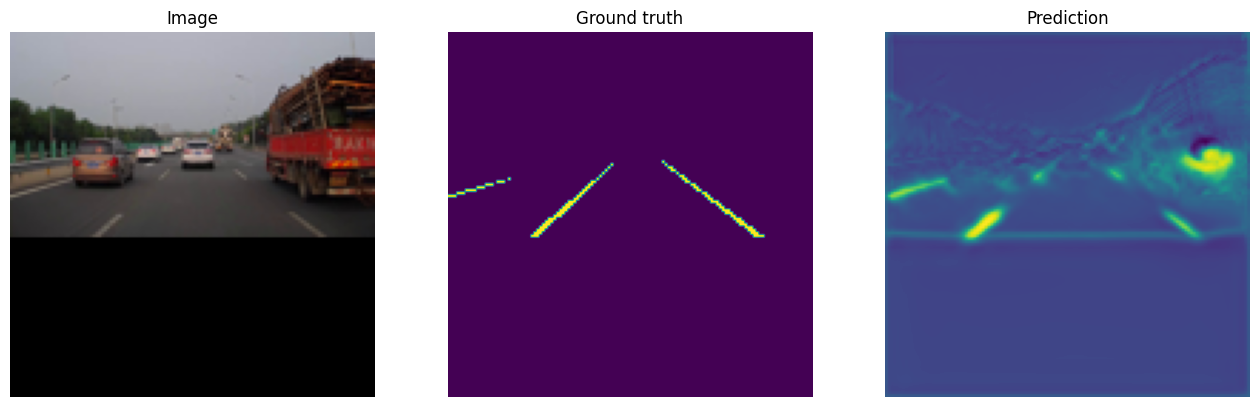

In [14]:
import matplotlib.pyplot as plt

batch = next(iter(val_dataloader))

with torch.no_grad():
    model.eval()
    logits = model(batch["image"].cuda())
    
pr_masks = logits.sigmoid()


for image, gt_mask, pr_mask in zip(batch["image"][:2], batch["mask"][:2], pr_masks[:2]):
    plt.figure(figsize=(16, 10))

    plt.subplot(1, 3, 1)
    plt.imshow(image.numpy().transpose(1, 2, 0))  # convert CHW -> HWC
    plt.title("Image")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(gt_mask.numpy().squeeze()) 
    plt.title("Ground truth")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(pr_mask.cpu().numpy().squeeze()) 
    plt.title("Prediction")
    plt.axis("off")

    plt.show()